# Tea Disease

## Import Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [37]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

## Import data 

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tea",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1929 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tea__algal_leaf',
 'Tea__anthracnose_2',
 'Tea__bird_eye_spot',
 'Tea__brown_blight',
 'Tea__healthy',
 'Tea__red_leaf_spot']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 5 2 2 2 5 4 0 4 5 2 5 0 2 1 5 5 5 5 5 4 4 0 2 0 3 3 0 0 0 0 5]


## Get some images from dataset 

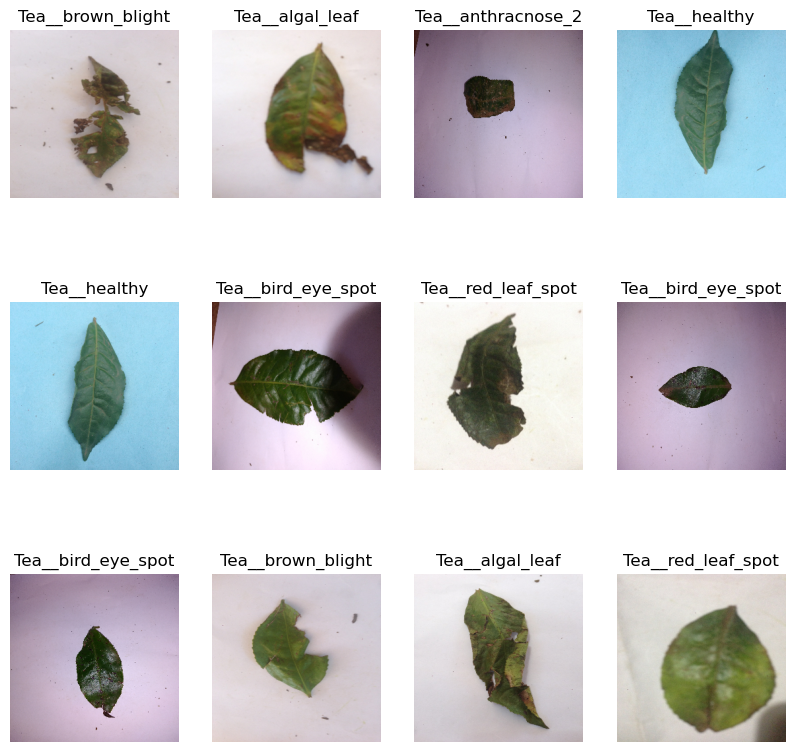

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

61

In [8]:
train_size = 0.8
len(dataset)*train_size

48.800000000000004

In [9]:
train_ds = dataset.take(48)
len(train_ds)

48

In [10]:
test_ds = dataset.skip(48)
len(test_ds)

13

In [11]:
val_size=0.1
len(dataset)*val_size

6.1000000000000005

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

7

In [14]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

48

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

7

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
48/48 [==============================] - 102s 2s/step - loss: 1.3932 - accuracy: 0.3635 - val_loss: 1.1091 - val_accuracy: 0.4792
Epoch 2/20
48/48 [==============================] - 65s 1s/step - loss: 0.9148 - accuracy: 0.5413 - val_loss: 1.1268 - val_accuracy: 0.5208
Epoch 3/20
48/48 [==============================] - 69s 1s/step - loss: 0.7534 - accuracy: 0.6008 - val_loss: 0.7421 - val_accuracy: 0.5885
Epoch 4/20
48/48 [==============================] - 69s 1s/step - loss: 0.7000 - accuracy: 0.6570 - val_loss: 0.6727 - val_accuracy: 0.6719
Epoch 5/20
48/48 [==============================] - 69s 1s/step - loss: 0.5984 - accuracy: 0.7118 - val_loss: 0.8092 - val_accuracy: 0.6458
Epoch 6/20
48/48 [==============================] - 70s 1s/step - loss: 0.5915 - accuracy: 0.7198 - val_loss: 0.5414 - val_accuracy: 0.7656
Epoch 7/20
48/48 [==============================] - 71s 1s/step - loss: 0.4828 - accuracy: 0.7892 - val_loss: 0.4390 - val_accuracy: 0.8177
Epoch 8/20
48/48 [=

In [27]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 31s 405ms/step - loss: 0.2506 - accuracy: 0.8929


In [28]:
scores

[0.25064733624458313, 0.8928571343421936]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 48}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

20

In [34]:
history.history['loss'][:5]

[1.3932430744171143,
 0.9148477911949158,
 0.7533522844314575,
 0.7000204920768738,
 0.5984197854995728]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

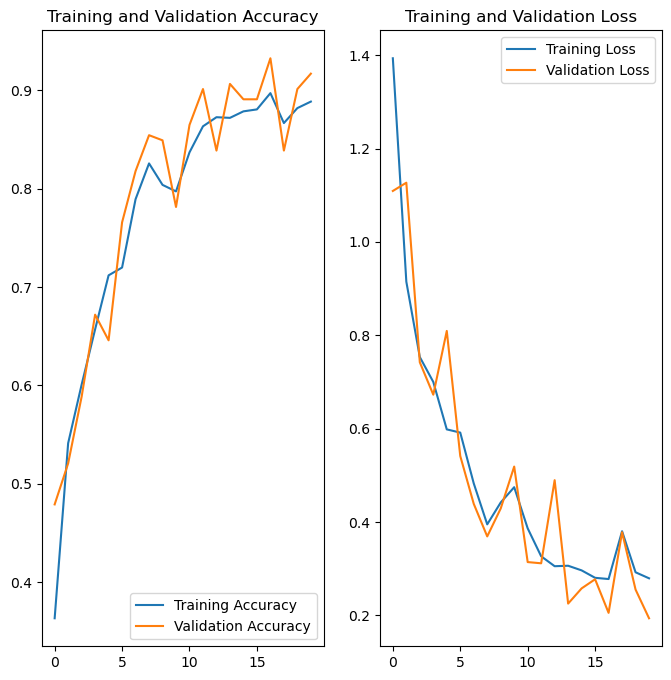

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tea__bird_eye_spot
1/1 [==============================] - 0s 469ms/step
predicted label: Tea__bird_eye_spot


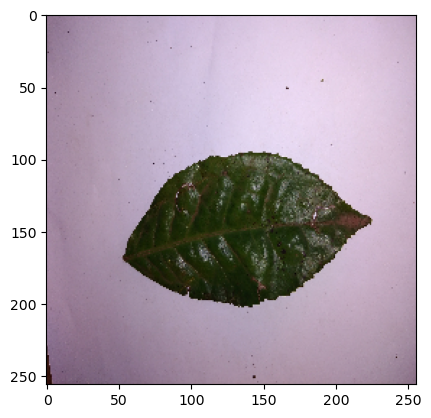

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


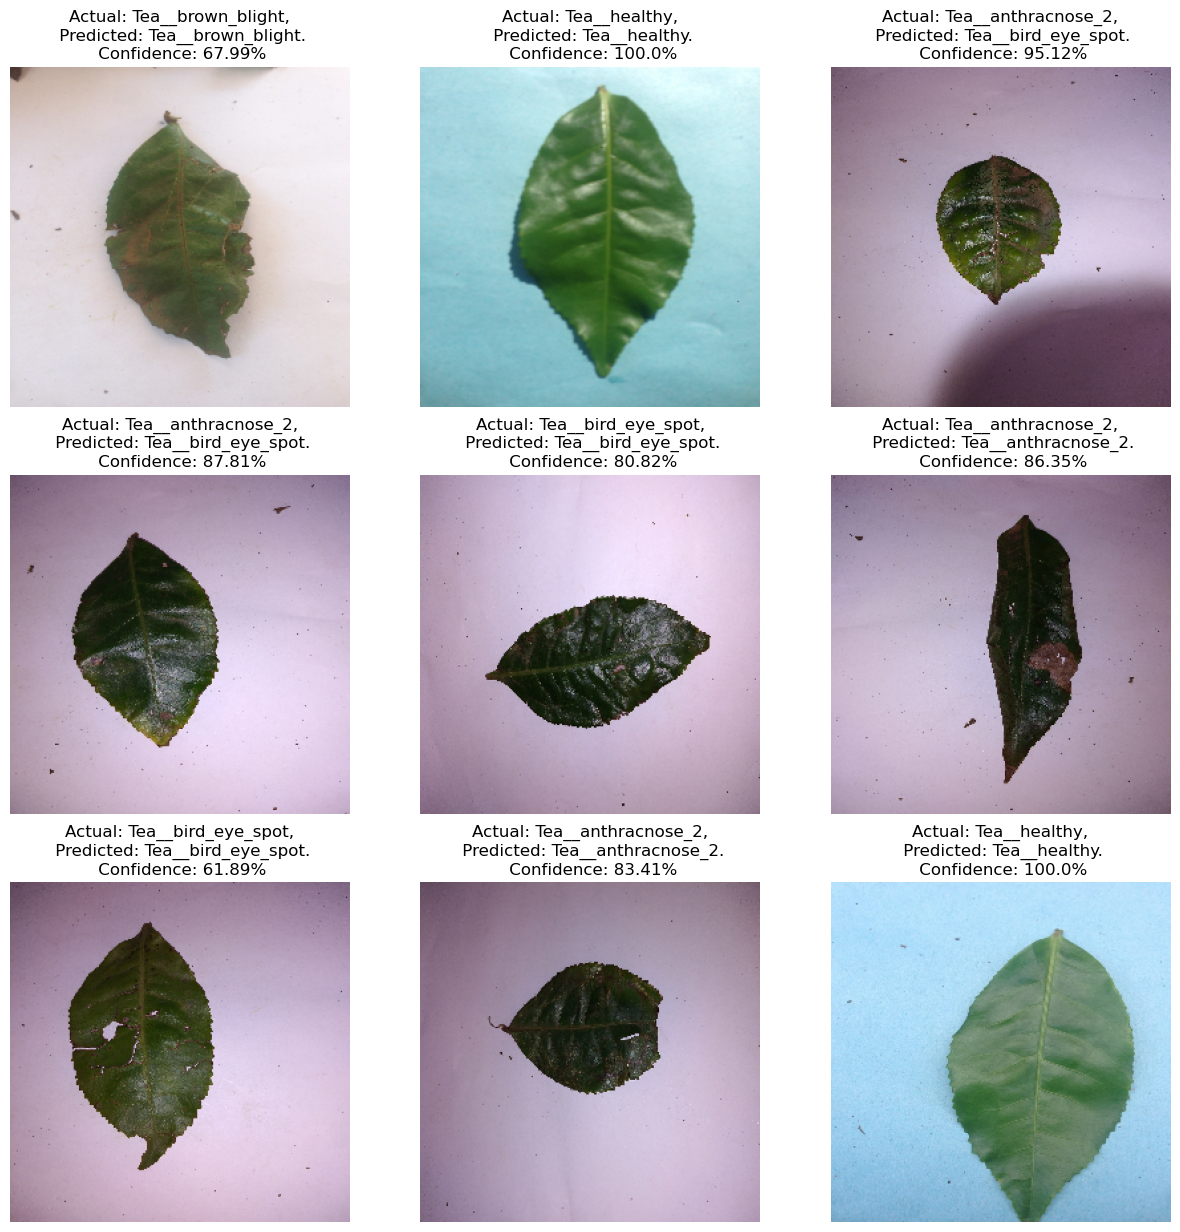

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
import os
model_version=max([int(i) for i in os.listdir("../model") + [0]])+1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets


In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
48/48 [==============================] - 61s 1s/step - loss: 0.2117 - accuracy: 0.9187 - val_loss: 0.2432 - val_accuracy: 0.8906
Epoch 2/40
48/48 [==============================] - 66s 1s/step - loss: 0.2722 - accuracy: 0.8909 - val_loss: 0.2093 - val_accuracy: 0.9583
Epoch 3/40
48/48 [==============================] - 68s 1s/step - loss: 0.2281 - accuracy: 0.9147 - val_loss: 0.1823 - val_accuracy: 0.9479
Epoch 4/40
48/48 [==============================] - 69s 1s/step - loss: 0.2034 - accuracy: 0.9207 - val_loss: 0.1760 - val_accuracy: 0.9271
Epoch 5/40
48/48 [==============================] - 69s 1s/step - loss: 0.2022 - accuracy: 0.9174 - val_loss: 0.1342 - val_accuracy: 0.9479
Epoch 6/40
48/48 [==============================] - 67s 1s/step - loss: 0.1594 - accuracy: 0.9405 - val_loss: 0.1235 - val_accuracy: 0.9479
Epoch 7/40
48/48 [==============================] - 69s 1s/step - loss: 0.1734 - accuracy: 0.9247 - val_loss: 0.1251 - val_accuracy: 0.9479
Epoch 8/40
48/48 [==

In [44]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 2s 354ms/step - loss: 0.3600 - accuracy: 0.8705


In [45]:
scores

[0.3599734902381897, 0.8705357313156128]